### [Trend Example 1](https://pmorissette.github.io/bt/examples.html#:~:text=rows%20%C3%97%202%20columns-,Trend%20Example%201,-import%20matplotlib.pyplot)

In [1]:
import warnings

import bt
import ffn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

In [2]:
rf = 0.04
np.random.seed(1)
# 평균 0.05, 표준편차 1, 갯수 5개
mus = np.random.normal(loc=0.05, scale=0.02, size=5) + rf
mus

array([0.12248691, 0.07776487, 0.07943656, 0.06854063, 0.10730815])

In [3]:
sigmas = (mus - rf) / 0.3 + np.random.normal(loc=0, scale=0.01, size=5)
sigmas

array([0.25194097, 0.14333102, 0.12384315, 0.09832582, 0.2218668 ])

In [4]:
num_years = 10
num_month_per_year = 12
num_days_per_month = 21
num_days_per_year = num_month_per_year * num_days_per_month

In [5]:
rdf = pd.DataFrame(
    index=pd.date_range(
        start="2008-01-02",
        periods=num_years * num_month_per_year * num_days_per_month,
        freq="B",
    ),
    columns=["foo", "bar", "baz", "fake1", "fake2"],
)

<Axes: >

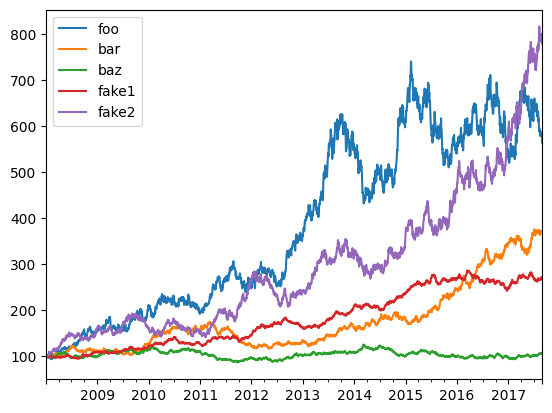

In [6]:
for i, mu in enumerate(mus):
    sigma = sigmas[i]
    rdf.iloc[:, i] = np.random.normal(
        loc = mu/num_days_per_year,
        scale=sigma/np.sqrt(num_days_per_year),
        size=rdf.shape[0]
    )
pdf = np.cumprod(1+rdf)*100
pdf.plot()

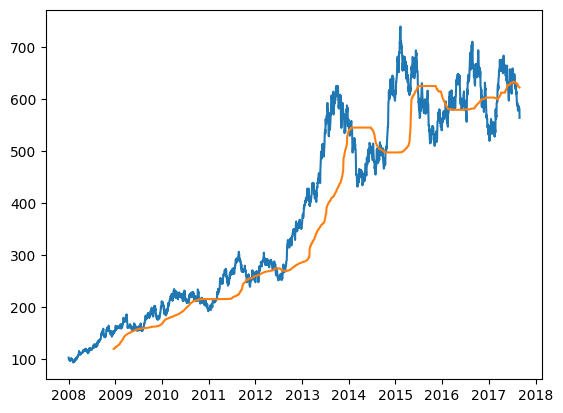

In [7]:
# create trend signal over the last 12 months
sma = pdf.rolling(window=num_days_per_month*12, center=False).median().shift(1)
plt.plot(pdf.index, pdf["foo"])
plt.plot(sma.index, sma["foo"])
plt.show()

In [8]:
trend = sma.copy()
trend

,foo,bar,baz,fake1,fake2
2008-01-02,NaN,NaN,NaN,NaN,NaN
2008-01-03,NaN,NaN,NaN,NaN,NaN
2008-01-04,NaN,NaN,NaN,NaN,NaN
2008-01-07,NaN,NaN,NaN,NaN,NaN
2008-01-08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2017-08-23,623.241267,340.774506,99.764885,263.491447,619.963986
2017-08-24,623.167989,341.096742,99.764885,263.502145,620.979948
2017-08-25,622.749149,341.316672,99.764885,263.502145,622.421401
2017-08-28,622.353039,341.494307,99.807732,263.517071,622.962579


In [9]:
trend[pdf > sma] = True
trend[pdf <= sma] = False
trend[sma.isnull()] = False
trend.tail()

,foo,bar,baz,fake1,fake2
2017-08-23,False,True,True,True,True
2017-08-24,False,True,True,True,True
2017-08-25,False,True,True,True,True
2017-08-28,False,True,True,True,True
2017-08-29,False,True,True,True,True


In [10]:
from bt.core import Strategy
from bt.algos import (
    RunDaily,
    SelectWhere,
    WeighInvVol,
    LimitWeights,
    Rebalance,
    WeighEqually,
)

# strategies

tsmom_invvol_strategy = Strategy(
    "tsmom_invvol",
    algos=[
        RunDaily(),
        SelectWhere(signal=trend), # 종목
        WeighInvVol(), # 비율 선택된 자산들의 비중을 역변동성 방식으로 설정한다. 즉, 변동성이 낮은 자산에 더 높은 비중을 두는 방식.
        LimitWeights(limit=0.4), # 비율 제한
        Rebalance(),
    ],
)

tsmom_ew_strategy = Strategy(
    "tsmom_ew",
    algos=[
        RunDaily(),
        SelectWhere(signal=trend), # 종목
        WeighEqually(), # 비율
        LimitWeights(limit=0.4), # 비율 제한
        Rebalance()
    ]
)

In [11]:

# backtest
from bt.backtest import Backtest

tsmom_invvol_backtest = Backtest(
    tsmom_invvol_strategy,
    pdf,
    name="tsmom_invvol_backtest",
    initial_capital=50000000.0,
    commissions=lambda q, p : abs(q) * p * 0.01 * 0.21, # 수수료 0.021%
    integer_positions=False,
    progress_bar=True
)


tsmom_ew_backtest = Backtest(
    tsmom_ew_strategy,
    pdf,
    name="tsmom_ew_backtest",
    initial_capital=50000000.0,
    commissions=lambda quantity, price: abs(quantity) * price *0.0021, # 수수료 0.21% 
    integer_positions=False,
    progress_bar=True
)

tsmom_invvol_result = bt.run(tsmom_invvol_backtest)
tsmom_ew_result = bt.run(tsmom_ew_backtest)

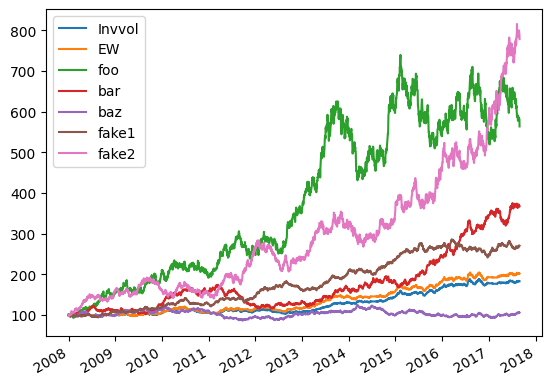

In [12]:
ax = plt.subplot()
ax.plot(tsmom_invvol_result.prices.index, tsmom_invvol_result.prices, label="Invvol")
ax.plot(tsmom_ew_result.prices.index, tsmom_ew_result.prices, label="EW")
pdf.plot(ax=ax)
ax.legend()
plt.legend()
plt.show()
# 일 단위로 거래하면.. 수수료때문에..